# SIR models without the calculus

**Benjamin Vincent, University of Dundee, [@inferenceLab](https://twitter.com/inferencelab)**

This work was inspired by a tweet by Chat Scherrer (https://twitter.com/ChadScherrer/status/1244289555403911168) who's doing some really nice work on probabilistic programming. The tweet pointed out that you need not evaluate SIR models using calculus. Instead, you can use discreete time and discrete counts and evaluate SIR models as a simple Markov chain.

So the code below is a quick Python implimentation of an SIRD (susceptible, infected, recovered, deceased) model. Note that this is just the forward model to simulate and predict for known parameters. There is no inferential fitting to data, which is what Chat Scherrer is working on.

_Note:_ this notebook is for educational purposes only. Model parameters were pretty much chosen at random, no effort to fit the parameters to data was made, so this is not meant to be a serious prediction of the current Covid-19 sitation. 

The schematic below shows the basic idea.
![Schematic of SIR model as Markov Chain](schematic.png)

Parameters:
- $\alpha$ = infection rate
- $\beta$ = probability of recovering _per day_ if you are infected
- $\gamma$ = probability of dying _per day_ if you are infected

In [1]:
using Distributions
using Plots

In [2]:
icuCapacity = 4562

4562

In [3]:
function simulate(parameters; N=66_440_000,i₀=100, maxT=1000)
    α, β, γ = parameters
    # define initial conditions
    s, i, r, d, N =([N-i₀], [i₀], [0], [0], [N])
    for t in [2:maxT;]
        # transitions
        si = rand(Binomial(s[end], (α * i[end]) / N[end]))
        ir = rand(Binomial(i[end], β))
        id = rand(Binomial(i[end], γ))
        # update counts
        push!(s, s[end] - si)
        push!(i, i[end] + si - ir - id)
        push!(r, r[end] + ir)
        push!(d, d[end] + id)
        push!(N, N[end] - id)
    end
    return (s, i, r, d, N)
end

simulate (generic function with 1 method)

In [4]:
s, i, r, d, N = simulate((0.2, 0.01, 0.02), i₀=100, maxT=1000);

## Plotting

In [5]:
function time_plot()
   # time plot
    p = plot(s, label="susceptible", lw=3, linecolour=:blue)
    plot!(i, label="infected", lw=3, linecolour=:red)
    plot!(r, label="recovered", lw=3, linecolour=:green)
    plot!(d, label="deceased", lw=3, linecolour=:black)
    plot!(N, label="total population", lw=3, linecolour=:black, linestyle=:dash)
    hline!([icuCapacity], label="UK ICU beds", linecolour=:blue)
    xlabel!("time [days]")
    ylabel!("frequency")
    return p
end

time_plot (generic function with 1 method)

In [6]:
function semilog_plot()
    # mortality time plot
    t = [1:length(d);]
    inc = d.>0
    p = plot(t[inc], d[inc], yaxis=:log, label="deceased", lw=3, linecolour=:black)
    
    inc = i.>0
    plot!(t[inc], i[inc], label="infected", yaxis=:log, lw=3, linecolour=:red)
    # plot!(N, label="total population", lw=3, linecolour=:black, linestyle=:dash)
    hline!([icuCapacity], label="UK ICU beds", linecolour=:blue)
    xlabel!("time [days]")
    ylabel!("frequency")
    return p
end

semilog_plot (generic function with 1 method)

In [7]:
function per_day_plot()
    # deaths per day
    deaths_per_day = d[2:end] - d[1:end-1]
    p = plot([2:1000], deaths_per_day, label="deaths per day", lw=3, linecolour=:black)
    
    # new cases per day
    cases_per_day = s[1:end-1] - s[2:end]
    plot!([2:1000], cases_per_day, label="new cases per day", lw=3, linecolour=:red)
    
    xlabel!("time [days]")
    ylabel!("frequency")
    return p
end

per_day_plot (generic function with 1 method)

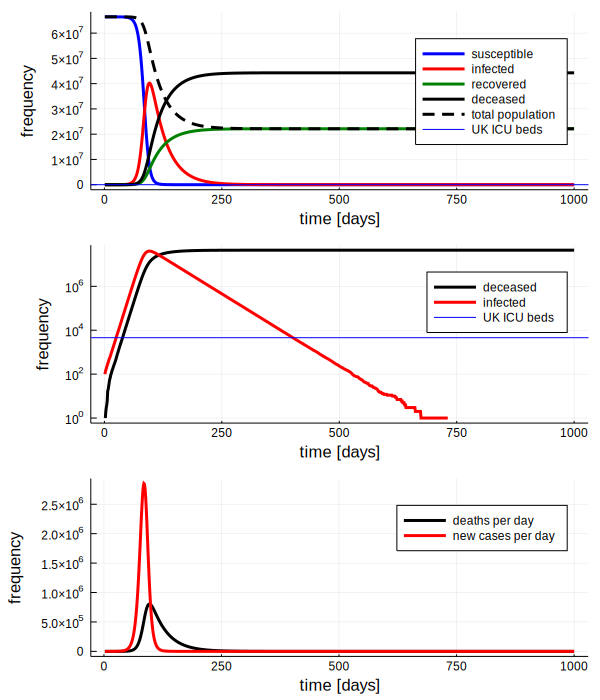

In [8]:
l = @layout [a ; b; c]
p1 = time_plot()
p2 = semilog_plot()
p3 = per_day_plot()
plot(p1, p2, p3, layout = l, size = (600, 700))